<a href="https://colab.research.google.com/github/Mingyuli1996/Stock-Price-Estimation/blob/master/Stock_price_multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [296]:
!pip install pykalman

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import datetime as dt
from datetime import datetime, timedelta
from pykalman import KalmanFilter
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
%matplotlib inline

In [0]:
def reduce_noise(X):
    index1=X.index.values
    name1=X.name
#This function applys kalman filter to reduce the noise in daily stock price
    kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = X.values[0],
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
    
    state_means,_ = kf.filter(X.values)
    state_means = state_means.flatten()
    state_means=pd.DataFrame(data=state_means, index = index1, columns=[name1])
#     state_means=state_means.astype(int) 
    return state_means

def get_prices(ticks, st, ed):
# This function gets Adjusted Closing prices from Yahoo Finance
# returns a DataFrame. Inputs are ticks (list of tickers), st (start date), ed (end date)
    for idx, ticker in enumerate(ticks):
        print(ticker)
        f = web.DataReader(ticker, 'yahoo', st, ed)['Adj Close']
        f.name = ticker
        if idx==0:
            df = f
        else:
            df = pd.concat([df, f], axis=1)
        return df


def denoise(data):
# This function denoise the whole dataset
    ticks=list(data.columns)
    for i  ,ticker in enumerate(ticks):
        print(ticker)
        f_clean=reduce_noise(data[ticker])
#         f_clean=pd.DataFrame(data=f_clean,index = data.index.values,columns=[ticker])
        if i ==0:
            data_clean=f_clean
        else:
            data_clean = pd.concat([data_clean, f_clean], axis=1)
    return data_clean

In [0]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [299]:
#get the data
start = dt.datetime(2009, 5, 1)
end   = dt.datetime(2019,5,1)

tickers = [['IBM','SPY','^TNX']]

df = get_prices(tickers, start, end)

['IBM', 'SPY', '^TNX']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


In [300]:
df=df.dropna(axis=0)
df.isnull().sum()

Symbols
IBM     0
SPY     0
^TNX    0
dtype: int64

In [0]:
#adjust the risk free rate price
df[['^TNX']]=(df[['^TNX']]+1)**(2.71828)

In [302]:
#Denoise the dataset
df_clean=denoise(df)

IBM
SPY
^TNX


Text(0.5, 1.0, 'Price Trend from 2009 to 2019')

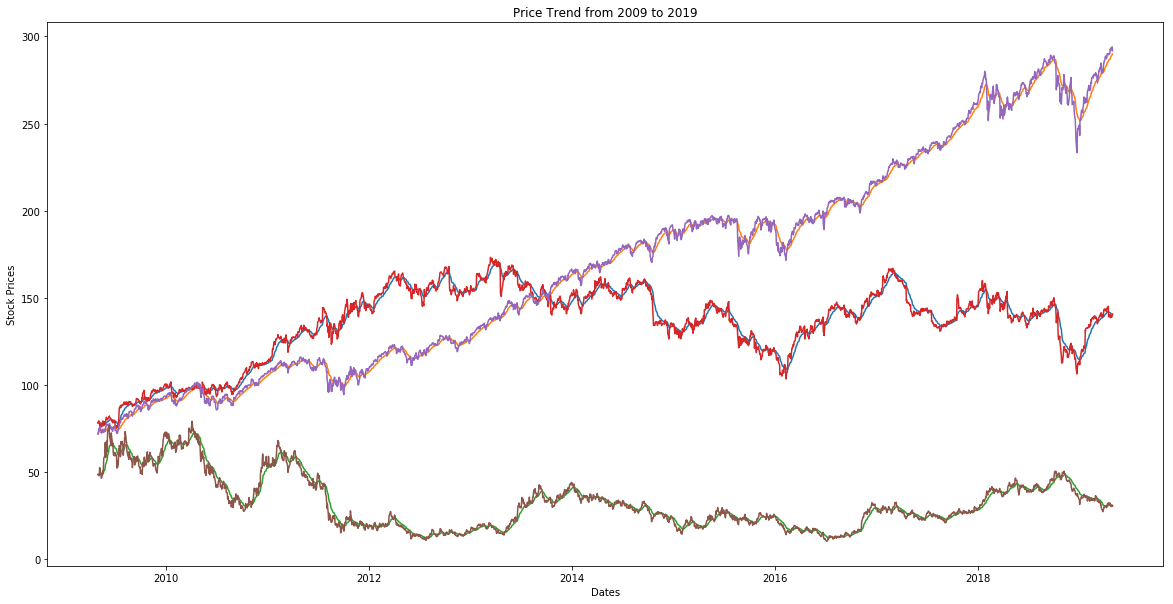

In [303]:
#plot the data
plt.plot(df_clean)
plt.plot(df)

plt.xlabel("Dates")
plt.ylabel("Stock Prices")
plt.title('Price Trend from 2009 to 2019')

In [304]:
#creating train and test sets
train_start_date = '2009-05-01'
train_end_date = '2017-04-30'
test_start_date = '2017-05-01'
test_end_date = '2019-05-01'
train = df.ix[train_start_date : train_end_date]
test= df.ix[test_start_date:test_end_date]
print(train.shape,test.shape)

(2011, 3) (504, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [0]:
#set lagging period
lagging=1

In [0]:
clean_dataset = df_clean.values
dataset = df.values

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_clean = scaler.fit_transform(clean_dataset)
scaled_data = scaler.fit_transform(dataset)

In [307]:
len_train=len(train)
len_train_lagging=len_train+lagging

X_train=scaled_data_clean[0:len_train,:]
y_train=scaled_data[lagging:len_train_lagging,0]

print(X_train.shape , y_train.shape)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

(2011, 3) (2011,)


In [314]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=2, verbose=1)

Epoch 1/10
2011/2011 [==============================] - 12s 6ms/step - loss: 0.0137
Epoch 2/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0030
Epoch 3/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0026
Epoch 4/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0024
Epoch 5/10
2011/2011 [==============================] - 8s 4ms/step - loss: 0.0021
Epoch 6/10
2011/2011 [==============================] - 8s 4ms/step - loss: 0.0019
Epoch 7/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0018
Epoch 8/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0018
Epoch 9/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0018
Epoch 10/10
2011/2011 [==============================] - 7s 4ms/step - loss: 0.0017


In [315]:
len_test=len(test)
len_total=len(scaled_data_clean)
len_test_lagging=len_total-lagging

X_test=scaled_data_clean[len_train:len_test_lagging,:]
y_test=dataset[len_train_lagging:,0]

print(X_test.shape , y_test.shape)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

(503, 3) (503,)


In [0]:
closing_price = model.predict(X_test)
adj_test=np.concatenate((closing_price,scaled_data_clean[len_train:len_total-1,1:]),axis=1)
adj_test=scaler.inverse_transform(adj_test)
closing_price =adj_test[:,0]

In [317]:
rms=np.sqrt(np.mean(np.power((y_test-closing_price),2)))
rms

4.732367924134783

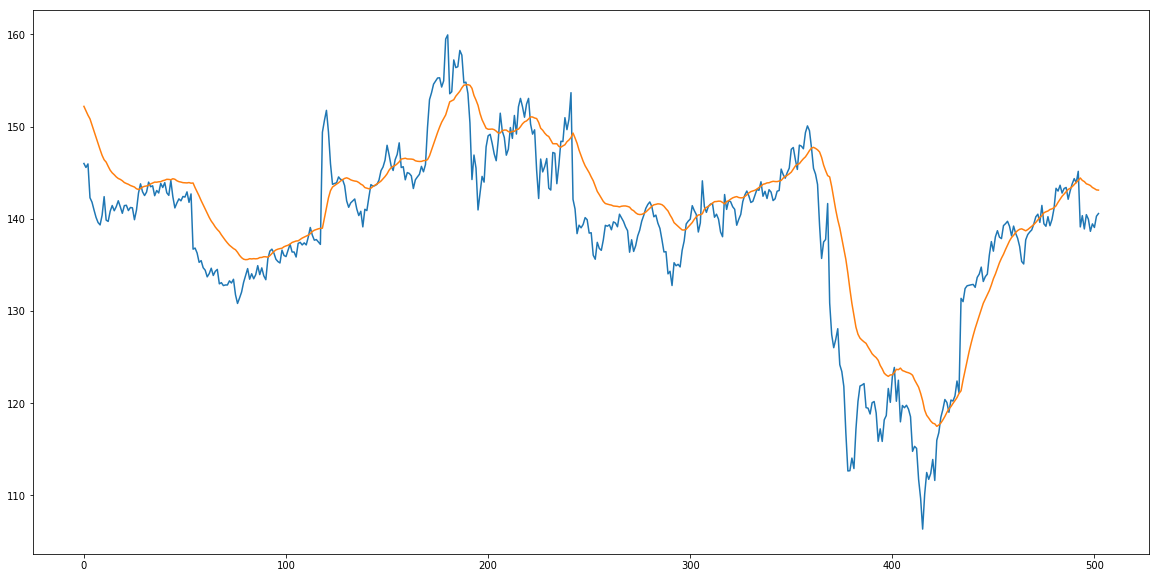

In [318]:
plt.plot(y_test)
plt.plot(closing_price)